# Lab 4. Data structures and arrays
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

Due: Sept. 21, 2023

---------

Adrian Marziliano

In [1]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime
from scipy import interpolate
from scipy.interpolate import interp1d


%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens

### Using data structures to categorize data

The file 'worldwide_m4+_2022.csv' (on canvas) contains all earthquakes larger than magnitude 4 recorded by the USGS in 2022 (more than 15,000 events). Let's use a dictionary to keep track of how many events happened in each state.

First, read the data into python using pandas. The column 'place' contains a short description of the location of each event, and if it occurred in the US, this description will (usually) mention a state name. We can find out if a string is contained in another string using the keyword 'in' (see the notes).

Instructions: loop over the list of state names, and for each state count the number of M4+ earthquakes that occurred in that state (you may need to loop over the whole dataset for each state name). Add this number to a dictionary with the state name as the key; for example it might contain 'New Mexico': 4.

Finally, print out the top 10 states by number of earthquakes in 2022.

In [2]:
earthquake_df=pd.read_csv('worldwide_m4+_2022.csv')
print(earthquake_df[['longitude', 'latitude', 'mag', 'place']])

       longitude  latitude  mag                                  place
0      -174.2142  -17.0269  4.6            126 km SSW of Hihifo, Tonga
1       124.3513   -8.7633  4.1  48 km N of Pante Makasar, Timor Leste
2        73.4827   38.7251  4.2        74 km NW of Murghob, Tajikistan
3       170.6075   54.3998  4.0      242 km NW of Attu Station, Alaska
4       157.8335   51.1975  4.6       98 km ESE of Ozernovskiy, Russia
...          ...       ...  ...                                    ...
15743   145.0542   13.9106  4.1        45 km NNE of Yigo Village, Guam
15744    76.6286   28.7191  4.1                         Haryana, India
15745   126.7058    2.1748  4.4        153 km WNW of Tobelo, Indonesia
15746  -179.7377  -17.7705  4.1             105 km ENE of Levuka, Fiji
15747   -69.6590  -16.5013  4.9           27 km NNE of Mazo Cruz, Peru

[15748 rows x 4 columns]


In [3]:
# Create list of states as the keys of your dictionary.
us_states = [ "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", 
             "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
             "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", 
             "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
             "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", 
             "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
             "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", 
             "Wisconsin", "Wyoming"]

# Create an empty dictionary to store the earthquake data
earthquake_data_dict = {
    "Time": [],
    "Latitude": [],
    "Longitude": [],
    "Depth": [],
    "Magnitude": [],
    "Place": []
}

# Iterate through the DataFrame and extract data for US state names
for index, row in earthquake_df.iterrows():
    if isinstance(row['place'], str):  # Check if 'place' is a string
        for state in us_states:
            if state in row['place']:
                earthquake_data_dict["Time"].append(row['time'])
                earthquake_data_dict["Latitude"].append(row['latitude'])
                earthquake_data_dict["Longitude"].append(row['longitude'])
                earthquake_data_dict["Depth"].append(row['depth'])
                earthquake_data_dict["Magnitude"].append(row['mag'])
                earthquake_data_dict["Place"].append(row['place'])
                break  # Break the loop once a match is found to avoid duplicate entries

# Convert the dictionary to a DataFrame if needed
earthquake_data_df = pd.DataFrame(earthquake_data_dict)

# Print or use the earthquake data as needed
print(earthquake_data_df[['Time', 'Magnitude', 'Place']])

                         Time  Magnitude                              Place
0    2022-01-01T02:51:57.266Z       4.00  242 km NW of Attu Station, Alaska
1    2022-01-02T14:36:05.058Z       4.20  256 km NW of Attu Station, Alaska
2    2022-01-03T11:58:59.113Z       4.20       61 km SE of Unalaska, Alaska
3    2022-01-04T00:13:26.770Z       4.25           8 km E of P?hala, Hawaii
4    2022-01-05T07:21:14.365Z       4.20           35 km SE of Mina, Nevada
..                        ...        ...                                ...
482  2022-12-24T20:48:58.541Z       4.60       124 km S of Unalaska, Alaska
483  2022-12-25T07:57:13.678Z       4.80    77 km W of Attu Station, Alaska
484  2022-12-25T13:27:37.139Z       4.40         86 km SE of Akutan, Alaska
485  2022-12-31T02:57:46.044Z       4.10          77 km NNE of Adak, Alaska
486  2022-12-31T06:13:27.088Z       4.60    51 km SSE of Sand Point, Alaska

[487 rows x 3 columns]


### Resampling a dataset

Often times, our data have values missing, large errors, or are unevenly sampled. In this case, we need to 'resample' the data onto a regular grid. This is also known as 'gridding' the data.

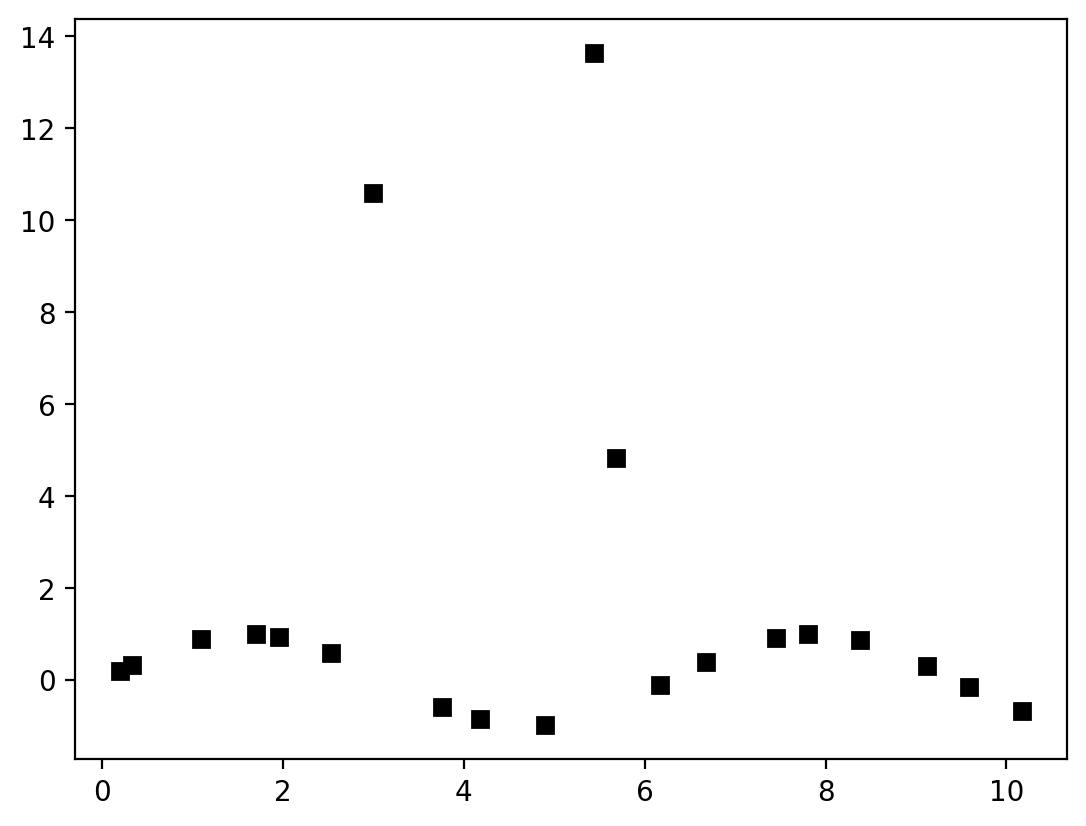

In [4]:
# original data - slight variation in the time sampling
time = np.linspace(0, 10, 20) +  np.random.uniform(-0.2, 0.2, 20)
values = np.sin(time)

# add some bad data
ibad=np.random.randint(2,18,(4,))
values[ibad] += 5+10*np.random.rand(4)

# plot the data
plt.plot(time,values,'ks',label='original')

### Assignment 1: remove outliers and resample the above data 

Step 1. Remove the outliers using logical indexing.

Step 2. Resample the remaining data onto a regularly spaced set of points sampled every 0.1 seconds, from 0 to 10. You can choose the interpolation method you find best!

Step 3. Plot the resampled data on top of the original data (without outliers), showing how the interpolation works.

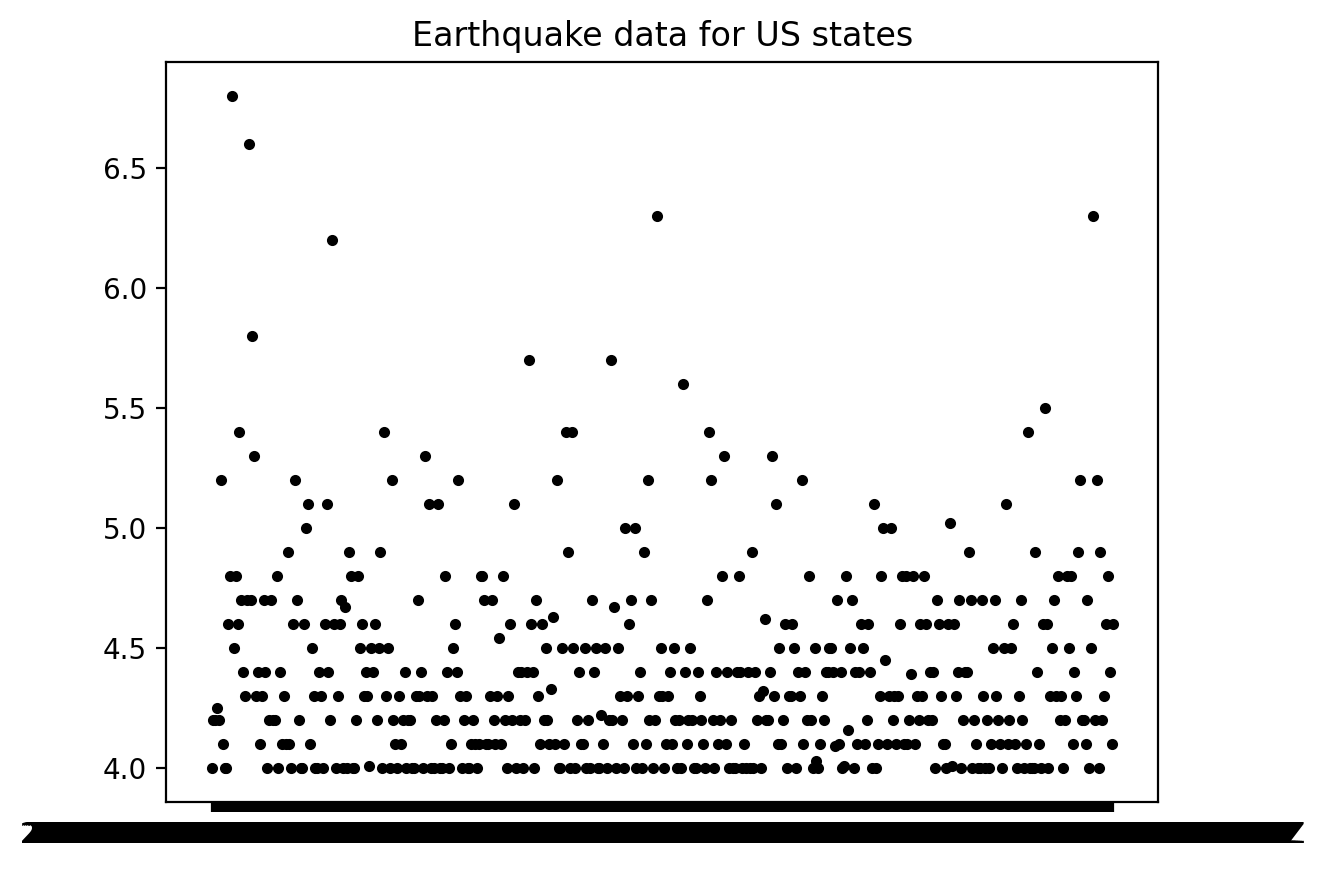

In [5]:
# Plot US earthquake data
plt.plot(earthquake_data_df['Time'],earthquake_data_df['Magnitude'],'k.')
plt.title('Earthquake data for US states')
plt.show()

#### STEP 1: Remove Outliers

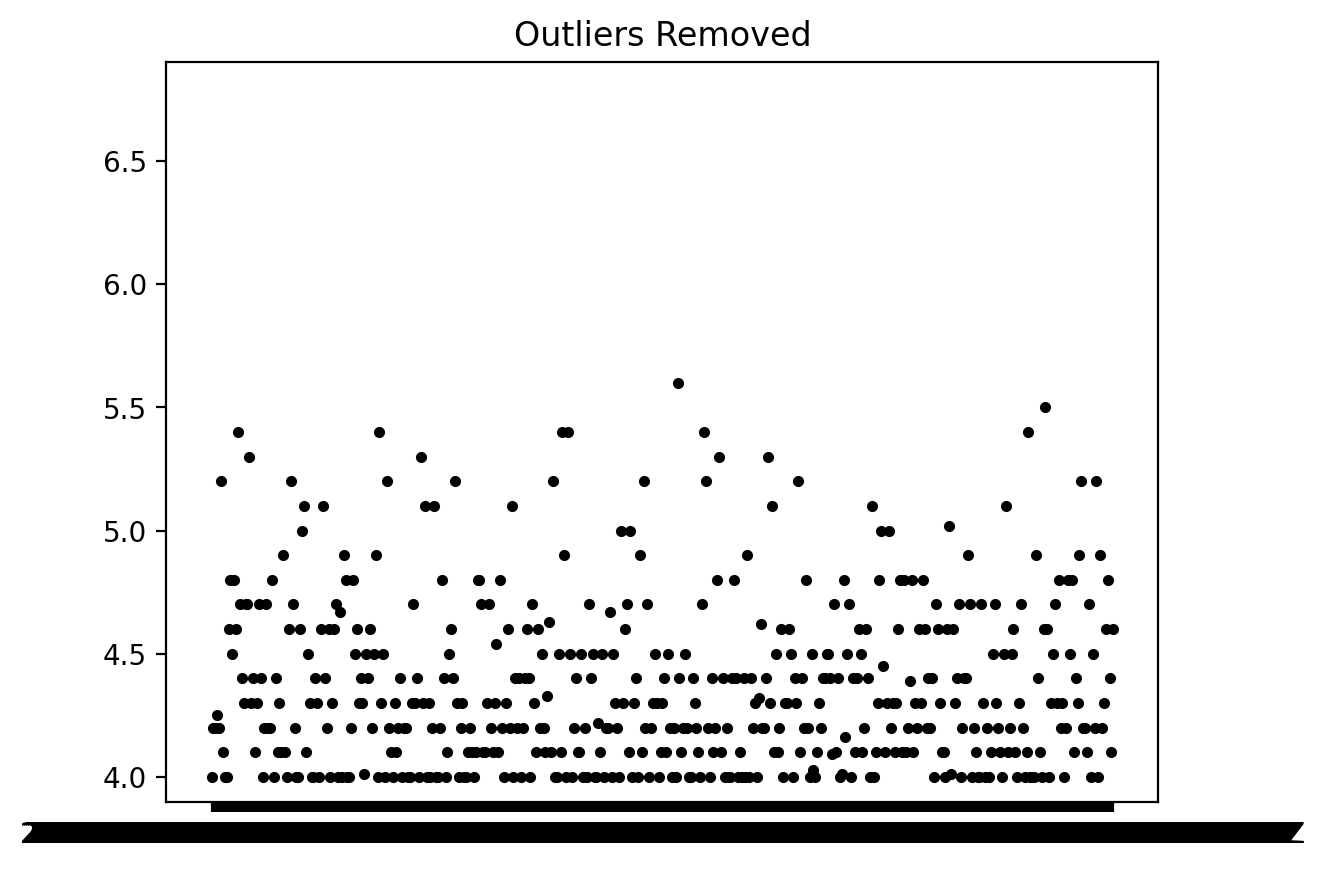

In [6]:
# Calculate mean and standard deviation for the 'mag' column
mean_magnitude = earthquake_data_df['Magnitude'].mean()
std_deviation_magnitude = earthquake_data_df['Magnitude'].std()

# Define a threshold for outliers (e.g., values more than 2 standard deviations from the mean)
threshold = 3 * std_deviation_magnitude

# Create a boolean mask identifying outliers
outliers_mask = np.abs(earthquake_data_df['Magnitude'] - mean_magnitude) > threshold

# Use the mask to filter the DataFrame and remove outliers
filtered_data = earthquake_data_df[~outliers_mask]

# Now, 'filtered_earthquake_df' contains the DataFrame with outliers removed.

# You can also reset the index if needed
filtered_data.reset_index(drop=True, inplace=True)

# Print or work with the filtered DataFrame as needed
#print(filtered_data)

# Plot US earthquake data W/O OUTLIERS
plt.plot(filtered_data['Time'],filtered_data['Magnitude'],'k.')
plt.title('Outliers Removed')
plt.ylim(3.9,6.9)
plt.show()

#### STEP 2: Resample Data

In [21]:
import pandas as pd
import numpy as np

# Sample earthquake magnitude data with NaN values (replace this with your data)

   # 'timestamp': pd.date_range(start='2022-01-01T02:51:57.266Z', end='2022-12-31T06:13:27.088Z', freq='ms'),
    #'magnitude': [3.0, 4.0, np.nan, 5.0, np.nan, 6.0, np.nan, 7.0, 8.0, np.nan]  # Replace this with your actual magnitude data

# Create a DataFrame
#df = pd.DataFrame(filterd_data)

# Sort the DataFrame by timestamp if it's not already sorted
filtered_data = filtered_data.sort_values(by='Time')

# Create a new datetime index with a 0.1-second frequency from 0 to 10 seconds
new_index = pd.date_range(start='2022-01-01T02:51:57.266Z', periods=1001, freq='100ms')

# Reindex the DataFrame with the new datetime index and use interpolation to fill missing values
filtered_data = filtered_data.set_index('Time').reindex(new_index)

# Interpolate the missing values using a method (e.g., linear or forward fill)
filtered_data['Magnitude'] = filtered_data['Magnitude'].interpolate(method='linear')

# Reset the index to include the timestamp column
filtered_data = filtered_data.reset_index()

# Now, df contains the earthquake magnitude data upsampled to the desired frequency with NaN values handled


: 

#### STEP 3: PLOT RESAMPLED DATA OVER ORIGINAL DATA

In [ ]:
# Plot US earthquake data W/O OUTLIERS
plt.scatter(resampled_data['index'], resampled_data['Magnitude'])

### Assignment 2. Use 2D Interpolation to fill in the continents.

Remember our averaged-monthly SST dataset? (Filename: 'sst.mon.ltm.1981-2010.nc') Let's use this as a (strange) example of interpolation. Try masking out the NaNs in the grid of temperatures from September, then use griddata to fill in all the values over the continents.

I think this will prove a litte challenging - good luck, work with each other!

In [ ]:
# here is some code to get you started.
# note you will have to copy the data file into your current folder for it to work for you.

filename = 'sst.mon.ltm.1981-2010.nc'
dataset = nc.Dataset(filename)

# sst is stored as a 3D array (time,lat,lon)
# get the grid in September
sst_sept = dataset['sst'][8,:,:]

# Hint: note that this netCDF dataset comes with a 'mask' property that lets us know which values are NaN.
# we can access them with sst_sept.mask

print('whether each point is nan:\n',sst_sept.mask)

# you can use this to extract only the valid data from any given array, if it has the same size
zvalid = sst_sept[~sst_sept.mask]

# check the shapes:
print('shape of sst_sept is', np.shape(sst_sept))
# notice, now it became a vector instead of an array.
print('shape of zvalid is', np.shape(zvalid))


#### I suggest the following procedure:

**Step 1. Generate the gridded X and Y matrices**

Use np.meshgrid on the dataset['lon'] and dataset['lat'] vectors.
Make sure to verify that your output arrays have the same size as your SST data.

**Step 2. Extract the valid points from each of your 3 arrays (X, Y, SST)**

Check out the hint above for how to use the mask property of the netcdf dataset.

**Step 3. Choose an interpolation method and do the interpolation from the scattered valid data back to the full X and Y grids**

**Step 4. Mask the ocean areas to show just the continents. You should end up with something cool!**